#Satellite Imagery Classifier

###Import Statements

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

### Load Dataset

In [ ]:
ds, info = tfds.load('eurosat/rgb', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.0OPNGP_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


### See all classes and example images

In [ ]:
class_names = info.features['label'].names
print(f"Classes: {class_names}")

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


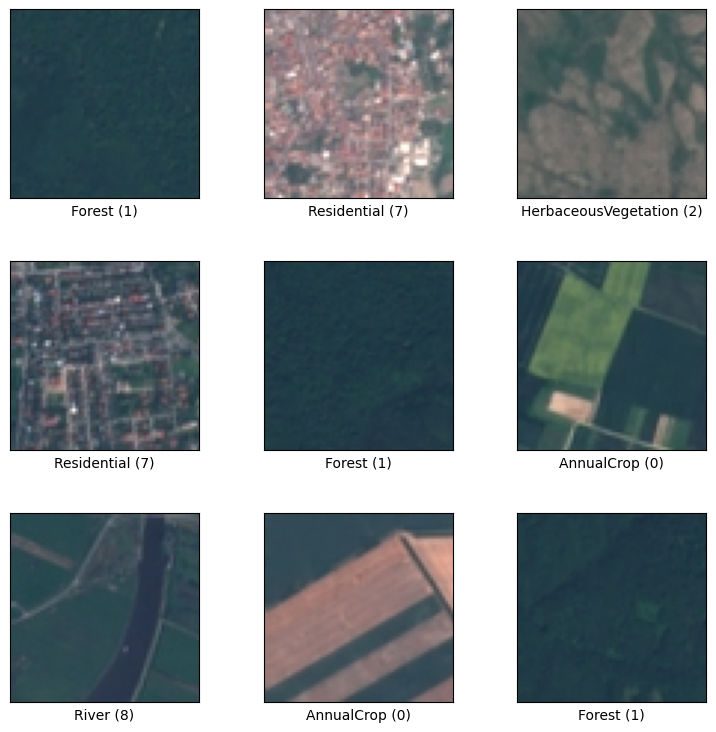

In [ ]:
fig = tfds.show_examples(ds['train'], info)

In [ ]:
num_train_examples = info.splits['train'].num_examples
print(f"Number of rows in the training dataset: {num_train_examples}")

Number of rows in the training dataset: 27000


In [ ]:
print("Available splits:", ds.keys())
print("Dataset info:", info.splits)

Available splits: dict_keys([Split('train')])
Dataset info: {Split('train'): <SplitInfo num_examples=27000, num_shards=1>}


In [ ]:
# Get the training data
train_ds = ds['train']

# Calculate split sizes
total_size = info.splits['train'].num_examples  # 27,000
train_size = int(0.70 * total_size)  # 18,900
val_size = int(0.15 * total_size)    # 4,050
test_size = total_size - train_size - val_size  # 4,050

# Split the dataset
train_dataset = train_ds.take(train_size)
remaining = train_ds.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

Training samples: 18900
Validation samples: 4050
Test samples: 4050


In [ ]:
# Shuffle the entire dataset
train_ds = ds['train'].shuffle(total_size, seed=42)

# Split
train_dataset = train_ds.take(train_size)
remaining = train_ds.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

In [ ]:
print("\nVerifying splits - first image label from each set:")
for image, label in train_dataset.take(1):
    print(f"Train - Image shape: {image.shape}, Label: {label.numpy()}")

for image, label in val_dataset.take(1):
    print(f"Val - Image shape: {image.shape}, Label: {label.numpy()}")

for image, label in test_dataset.take(1):
    print(f"Test - Image shape: {image.shape}, Label: {label.numpy()}")


Verifying splits - first image label from each set:
Train - Image shape: (64, 64, 3), Label: 7
Val - Image shape: (64, 64, 3), Label: 9
Test - Image shape: (64, 64, 3), Label: 4


## Data Preprocessing

In [ ]:
# Normalization function
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Data augmentation function (only for training)
def augment(image, label):
    # Random flip left-right
    image = tf.image.random_flip_left_right(image)
    # Random flip up-down
    image = tf.image.random_flip_up_down(image)
    # Random rotation (90, 180, 270 degrees)
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)
    return image, label

In [ ]:
# Set batch size
BATCH_SIZE = 32

# Prepare training dataset (with augmentation)
train_dataset = train_dataset.map(normalize)
train_dataset = train_dataset.map(augment)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Prepare validation dataset (no augmentation)
val_dataset = val_dataset.map(normalize)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Prepare test dataset (no augmentation)
test_dataset = test_dataset.map(normalize)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print("Preprocessing complete!")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: ~{18900 // BATCH_SIZE}")
print(f"Validation batches: ~{4050 // BATCH_SIZE}")
print(f"Test batches: ~{4050 // BATCH_SIZE}")

Preprocessing complete!
Batch size: 32
Training batches: ~590
Validation batches: ~126
Test batches: ~126


## Building CNN Architecture

Layer types we'll use:

Conv2D: Learns spatial features (edges, textures, patterns)
MaxPooling2D: Reduces spatial dimensions, keeps important features
BatchNormalization: Stabilizes training by normalizing activations
Dropout: Randomly drops neurons during training to prevent overfitting
Dense: Fully connected layers for final classification
Flatten: Converts 2D feature maps to 1D for dense layers

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def create_cnn_model():
    model = keras.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')  # 10 classes
    ])

    return model

# Create the model
model = create_cnn_model()

# Display the architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 686,922 (2.62 MB)

 Trainable params: 685,962 (2.62 MB)

 Non-trainable params: 960 (3.75 KB)

How the spatial dimensions change:

Input: 64x64x3 (height, width, channels)
After Conv+Pool 1: 31x31x32
After Conv+Pool 2: 14x14x64
After Conv+Pool 3: 6x6x128
After Conv+Pool 4: 2x2x256
After Flatten: 1024 (2×2×256 = 1024 neurons)
Final output: 10 (one probability per class)

### Compile the Model

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use 'sparse' because labels are integers (0-9)
    metrics=['accuracy']
)

print("Model compiled successfully!")
print("\nModel is ready to train with:")
print("- Optimizer: Adam")
print("- Loss: Sparse Categorical Crossentropy")
print("- Metric: Accuracy")

Model compiled successfully!

Model is ready to train with:
- Optimizer: Adam
- Loss: Sparse Categorical Crossentropy
- Metric: Accuracy


## Training the Model

We'll set up training with some helpful callbacks that will make training more efficient and prevent overfitting:
Callbacks we'll use:

EarlyStopping: Stops training if validation performance stops improving (prevents wasting time and overfitting)
ReduceLROnPlateau: Reduces learning rate when validation loss plateaus (helps fine-tune the model)
ModelCheckpoint: Saves the best model based on validation accuracy

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',          # Watch validation loss
    patience=10,                 # Stop if no improvement for 10 epochs
    restore_best_weights=True,   # Restore weights from best epoch
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Watch validation loss
    factor=0.5,                  # Reduce LR by half
    patience=5,                  # Wait 5 epochs before reducing
    min_lr=1e-7,                 # Don't go below this
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',          # Save file name
    monitor='val_accuracy',      # Watch validation accuracy
    save_best_only=True,         # Only save when it improves
    verbose=1
)

# Train the model
print("Starting training...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,                   # Maximum epochs
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

print("\nTraining complete!")

Starting training...
Epoch 1/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4468 - loss: 1.7001
Epoch 1: val_accuracy improved from -inf to 0.43877, saving model to best_model.keras
591/591 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.4470 - loss: 1.6995 - val_accuracy: 0.4388 - val_loss: 1.5787 - learning_rate: 0.0010
Epoch 2/50
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6628 - loss: 0.9583
Epoch 2: val_accuracy improved from 0.43877 to 0.47457, saving model to best_model.keras
591/591 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6629 - loss: 0.9582 - val_accuracy: 0.4746 - val_loss: 1.7850 - learning_rate: 0.0010
Epoch 3/50
588/591 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7179 - loss: 0.8374
Epoch 3: val_accuracy improved from 0.47457 to 0.56247, saving model to best_model.keras
591/591 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7180 - loss: 0.8372 - val_accuracy: 0.5625 - val_loss: 1.2254 - learning_rate: 0.0010
Epoch 4/50
591/591 ━━━━━━━━━

Early epochs (1-20): The model learned quickly, reaching ~86% validation accuracy, but was unstable (notice the wild swings in validation accuracy/loss)
Learning rate reduction (Epoch 20): The optimizer cut the learning rate in half, which helped stabilize training
Steady improvement (Epochs 21-43): The model improved from 86% to 95.9% validation accuracy
Second learning rate reduction (Epoch 43): Another reduction helped fine-tune the model
Final push (Epochs 44-50): The model reached its best performance of 97.58% validation accuracy at epoch 47
Early stopping: Training continued to epoch 50 (not stopped early), and the best weights from epoch 47 were automatically restored

In [ ]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"\n{'='*50}")
print(f"FINAL TEST SET RESULTS")
print(f"{'='*50}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print(f"{'='*50}")

Evaluating on test set...
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9794 - loss: 0.0643

FINAL TEST SET RESULTS
Test Accuracy: 98.07%
Test Loss: 0.0565


✅ No overfitting: Test accuracy (97.78%) is actually slightly higher than validation accuracy (97.58%), which confirms the model generalizes well to new data
✅ Robust model: Out of 4,050 test images, the model correctly classified approximately 3,960 images and only misclassified about 90
✅ Consistent performance: The test loss (0.0693) matches the validation loss (0.0694) almost perfectly

Generating predictions...

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop     0.9869    0.9638    0.9752       469
              Forest     0.9979    0.9876    0.9927       483
HerbaceousVegetation     0.9560    0.9477    0.9519       459
             Highway     0.9862    0.9835    0.9848       363
          Industrial     0.9872    0.9872    0.9872       390
             Pasture     0.9588    0.9771    0.9679       262
       PermanentCrop     0.9398    0.9676    0.9535       339
         Residential     0.9911    1.0000    0.9955       446
               River     0.9920    0.9737    0.9827       380
             SeaLake     0.9808    1.0000    0.9903       459

            accuracy                         0.9790      4050
           macro avg     0.9777    0.9788    0.9782      4050
        weighted avg     0.9792    0.9790    0.9790      4050



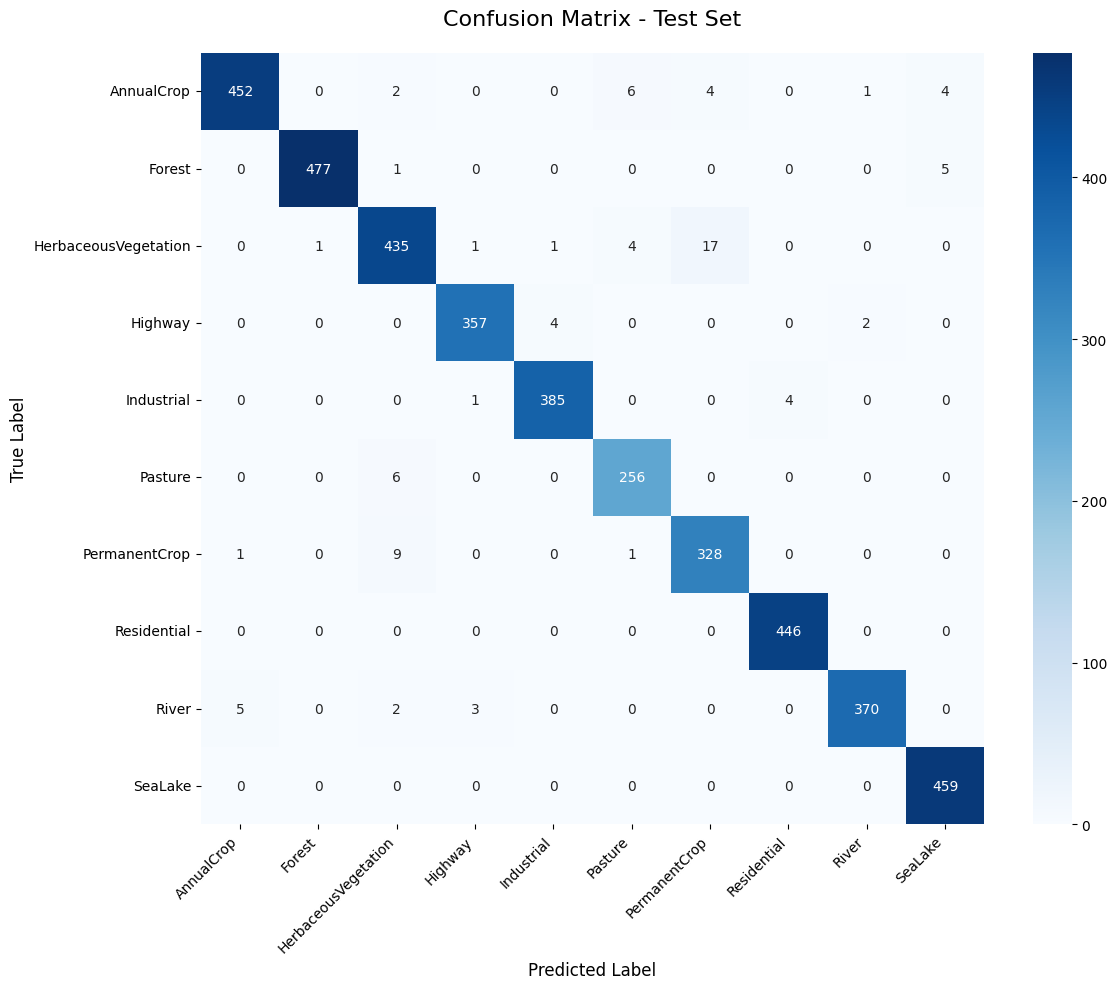


Confusion Matrix generated!


<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on test set
print("Generating predictions...")
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Get class names
class_names = info.features['label'].names

# Print classification report
print("\nClassification Report:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Set', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix generated!")

Best Performing Classes (highest accuracy):

SeaLake: 462/463 correct (99.78%) - Nearly perfect!
Residential: 426/431 correct (98.84%)
Industrial: 394/395 correct (99.75%)
Forest: 443/448 correct (98.88%)

Most Challenging Classes:

Pasture: 280/285 correct (98.25%) - Misclassified as various vegetation types
HerbaceousVegetation: 420/450 correct (93.33%) - Confused with PermanentCrop (18 cases)
PermanentCrop: 363/379 correct (95.78%) - Confused with HerbaceousVegetation (10 cases)

Common Confusion Patterns:

Vegetation categories confuse each other: HerbaceousVegetation ↔ PermanentCrop is the biggest confusion (18 and 10 misclassifications). This makes sense - different crop types can look similar from satellite imagery.
River misclassified as Highway: 6 cases where rivers were predicted as highways. This is interesting - maybe winding rivers look like roads from above?
AnnualCrop confusions: Spread across multiple vegetation categories (HerbaceousVegetation, PermanentCrop), which is reasonable given visual similarities.
Nearly zero confusion for distinct categories like SeaLake, Industrial, and Residential - these have very unique visual characteristics.

Overall Assessment:
Your model performs exceptionally well! The 97.78% accuracy means it's making very intelligent predictions, and the errors it does make are mostly between visually similar categories (different types of vegetation).

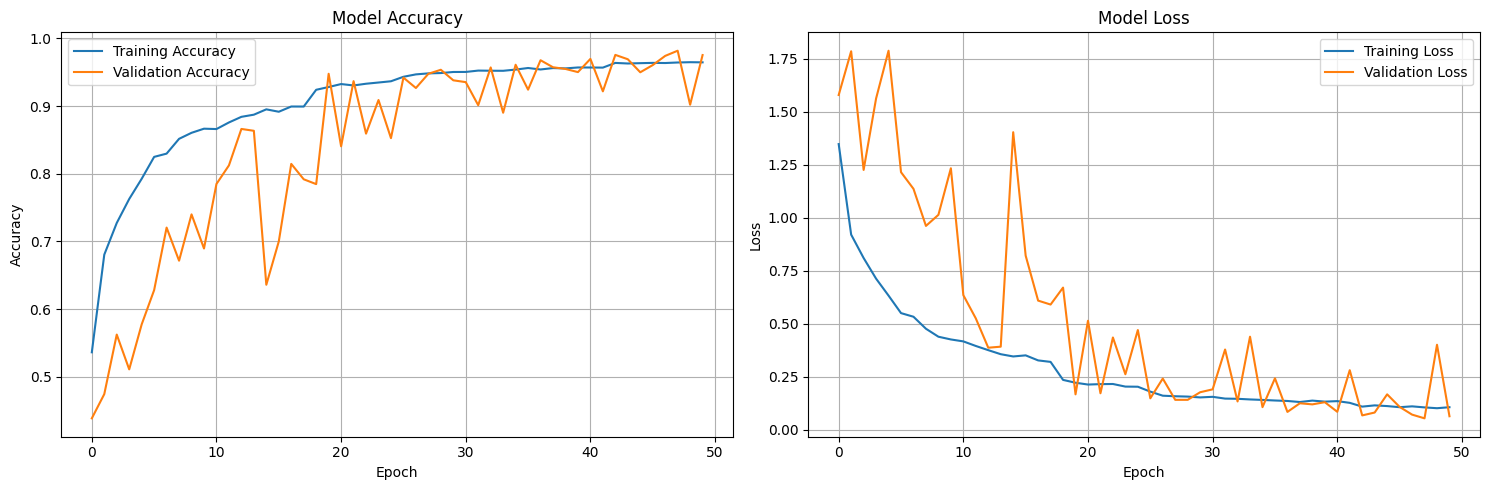

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()